## Word-Level로 번역기 업그레이드하기
주어진 데이터에서 상위 33,000개의 샘플만 사용.  
33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트하는 용도로 사용.  
  
### Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두)
---
단어 단위 번역기를 하기 위해 고려해야할 사항들  
  
1. 구두점(Punctuation)을 단어와 분리하기.
   Tokenization이라고 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업.  
2. 소문자로 바꾸기
3. 띄어쓰기 단위로 토큰 수정행하기

In [1]:
#필요한 패키지 import
#데이터 load 및 전처리
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


In [2]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.head()

전체 샘플의 수 : 178009


,eng,fra,cc
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Run!,Cours !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Run!,Courez !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [3]:
lines.sample(5)

,eng,fra,cc
139797,I've heard that name somewhere before.,J'ai déjà entendu ce nom quelque part.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
145634,How did you happen to see them doing it?,Comment se fait-il que vous les ayez vues en t...,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
16201,Say it in French.,Dites-le en français.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
7947,I felt cheated.,Je me suis sentie trompée.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
47201,Don't be so hard on me.,Ne soyez pas si dure envers moi.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


In [4]:
#학습에 사용할 상위 33000개의 데이터만 뽑아 온다.
lines = lines[['eng', 'fra']][:33000]
lines.sample(5)

,eng,fra
11310,I remembered it.,Je m'en souvenais.
4465,They're dead.,Elles sont décédées.
31528,She turned him down.,Elle l'a éconduit.
29250,His novel sold well.,Son roman se vendit bien.
28450,Did I tell you that?,Vous ai-je conté cela ?


In [5]:
def preprocess_sentence(sent):
    sent = sent.lower()
    #단어와 구두점 사이 공백
    sent = re.sub(r"([?.!])",r" \1 ", sent)
    
    #남길 단어 이외 단어들은 전부 공백(한 칸 띄어쓰기)
    sent = re.sub(r"[^a-zA-Z?.!]+", r" ", sent)
    
    #공백 관리하기
    sent = re.sub(r'\s+', " ", sent)
    sent = sent.strip()
    
    return sent

In [6]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"
print(preprocess_sentence(en_sent))
print(preprocess_sentence(fr_sent).encode('utf-8'))

have you had dinner ?
b'avez vous d j din ?'


In [7]:
encoder_input = [preprocess_sentence(x).split() for x in lines.eng]

In [8]:
len(encoder_input)

33000

In [9]:
fra_sent = [preprocess_sentence(x) for x in lines.fra]

In [10]:
a = [w for w in ("<sos> " + fra_sent[0]).split()]
a

['<sos>', 'va', '!']

### Step 2. 디코더의 문장에서 시작 토큰과 종료 토큰 넣기
---
디코더의 입력 시퀀스 맨 앞에는 시작을 의미하는 토큰이 필요하다. 그리고 교사 강요를 수행할 때, 디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는 종료 토큰이 필요하다.

In [11]:
def teacher_forcing(sents):
    '''
    target sentence에 대하여
    decoder_input => decoder input : <sos> + sentence 와
    decoder_target => target line : sentence + <eos>를 생성
    '''
    decoder_input, decoder_target = [], []
    
    for sent in sents:
        tar_line_input = [w for w in ("<sos> " + sent).split()]
        decoder_input.append(tar_line_input)
        
        tar_line_target = [w for w in (sent + " <eos>").split()]
        decoder_target.append(tar_line_target)
        
    return decoder_input, decoder_target

In [12]:
decoder_input, decoder_target = teacher_forcing(fra_sent)

In [13]:
print(encoder_input[:5])
print(decoder_input[:5])
print(decoder_target[:5])

[['go', '.'], ['hi', '.'], ['hi', '.'], ['run', '!'], ['run', '!']]
[['<sos>', 'va', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.'], ['<sos>', 'cours', '!'], ['<sos>', 'courez', '!']]
[['va', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>'], ['cours', '!', '<eos>'], ['courez', '!', '<eos>']]


## Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꾸자.
---
참고 : https://wikidocs.net/31766  
  
위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고,  
tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보자.

In [14]:
def tokenize(encoder_input,decoder_input,decoder_target, _type='encoder'):
    tokenizer = Tokenizer(filters="",
                         lower=False, oov_token="<unk>")
    
    if _type == 'encoder':
        tokenizer.fit_on_texts(encoder_input)
        tensor = tokenizer.texts_to_sequences(encoder_input)
        tensor = pad_sequences(tensor, padding='post')
        return tensor, tokenizer
    
    elif _type == 'decoder':
        tokenizer.fit_on_texts(decoder_input)
        tokenizer.fit_on_texts(decoder_target)
        dec_tensor = tokenizer.texts_to_sequences(decoder_input)
        tar_tensor = tokenizer.texts_to_sequences(decoder_target)
        dec_tensor = pad_sequences(dec_tensor, padding='post')
        tar_tensor = pad_sequences(tar_tensor, padding='post')
        return dec_tensor, tar_tensor, tokenizer

In [15]:
eng2vector, tokenizer_eng = tokenize(encoder_input,decoder_input, decoder_target,_type='encoder')

In [16]:
dec2vector, tar2vector, tokenizer_fra = tokenize(encoder_input,decoder_input, decoder_target,_type='decoder')

In [17]:
#토큰화된 eng, fra_dec, fra_target shape 확인하기
print(np.shape(eng2vector))
print(np.shape(dec2vector))
print(np.shape(tar2vector))

(33000, 8)
(33000, 16)
(33000, 16)


>샘플은 총 33,000개 존재하며 영어 문장의 길이는 8, 프랑스어 문장의 길이는 16이다. 단어 집합의 크기를 정의한다.  
<a herf="https://wikidocs.net/86900">2) Word-Level 번역기 만들기(Neural Machine Translation (seq2seq) Tutorial)</a>

In [18]:
src_vocab_size = len(tokenizer_eng.word_index) +1
tar_vocab_size = len(tokenizer_fra.word_index) +1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4663, 프랑스어 단어 집합의 크기 : 7327


In [19]:
#dictionary_1 : key(word) : value(num)
#dictionary_2 : key(num) : value(word)
#딕셔너리 타입으로 단어와 토큰, 토큰과 단어가 연결되어 있는 사전을 미리 받아두자

src_to_index = tokenizer_eng.word_index
index_to_src = tokenizer_eng.index_word # 훈련 후 결과 비교할 때 사용

tar_to_index = tokenizer_fra.word_index # 훈련 후 예측 과정에서 사용
index_to_tar = tokenizer_fra.index_word # 훈련 후 결과 비교할 때 사용

>테스트 데이터를 분리할 차례이다. 테스트 데이터를 분리하기 전에, 적절한 분포를 갖도록 데이터를 섞어주는 과정을 진행한다. 이를 위해서 우선 순서가 섞인 정수 시퀀스 리스트를 만든다.  
  
왜냐하면 우리는 데이터셋 상위 33,000개의 데이터를 가져왔기 때문에 데이터셋 순서대로 학습을 시키는 것은 모델이 loss를 minimize하는 것을 힘들게 한다. 힘든건 나로 충분하니까 데이터를 잘 섞어주자.  
  
<a href=https://datascience.stackexchange.com/questions/24511/why-should-the-data-be-shuffled-for-machine-learning-tasks>Why should the data be shuffled for machine learning tasks</a>

In [20]:
indices = np.arange(eng2vector.shape[0])
np.random.shuffle(indices)
print(indices)

[10191 10713 31923 ... 26475 14406 18229]


In [21]:
eng2vector = eng2vector[indices]
dec2vector = dec2vector[indices]
tar2vector = tar2vector[indices]

In [22]:
#셔플링이 잘 이루어졌는지 확인해보자
print(eng2vector[28256])
print(dec2vector[28256])
print(tar2vector[28256])

[23  4 97 42  5  0  0  0]
[   3    6   29   34    8 1277   65    7    0    0    0    0    0    0
    0    0]
[   6   29   34    8 1277   65    7    4    0    0    0    0    0    0
    0    0]


In [23]:
#데이터셋 10%를 테스트 데이터로 분리하기
num_of_testset = int(33000*0.1)
print(num_of_testset)

3300


In [24]:
eng2vector_train = eng2vector[:-num_of_testset]
dec2vector_train = dec2vector[:-num_of_testset]
tar2vector_train = tar2vector[:-num_of_testset]

eng2vector_test = eng2vector[-num_of_testset:]
dec2vector_test = dec2vector[-num_of_testset:]
tar2vector_test = tar2vector[-num_of_testset:]

In [25]:
print(eng2vector_train.shape)
print(dec2vector_train.shape)
print(tar2vector_train.shape)
print(eng2vector_test.shape)
print(dec2vector_test.shape)
print(tar2vector_test.shape)

(29700, 8)
(29700, 16)
(29700, 16)
(3300, 8)
(3300, 16)
(3300, 16)


### Step 4. 임베딩 층 (Embedding layer)사용하기
---
1. 케라스 임베딩 층(keras Embedding layer) 참고하기
https://wikidocs.net/33793  
  
```python
from tensorflow.keras.layers import Input, Embedding, Masking

# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(단어장의 크기, 임베딩 벡터의 차원)(encoder_inputs)
encoder_lstm = LSTM(hidden state의 크기, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
```  
  
주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야하지만,  
디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야한다.

### import

In [26]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from CosineAnnealing import CosineAnnealingScheduler

In [129]:
latent_dim = 250
epochs = 100

In [130]:
#model checkpoint
import os

chekpoint_filepath = os.getenv('HOME') + '/project/E15/tmp/chekpoint'
model_checkpoint_callback = ModelCheckpoint(
                            filepath = chekpoint_filepath,
                            monitor='val_acc',
                            save_weights_only=True,
                            mode='max',
                            save_freq='epoch')

In [131]:
earlystopping_callback = EarlyStopping(monitor='val_acc',
                                      patience=10,
                                      mode='auto')

In [132]:
scheduler_callback = CosineAnnealingScheduler(T_max=epochs, eta_max=0.05, eta_min=1e-2, verbose=1)

In [162]:
callback = [model_checkpoint_callback]

In [163]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(src_vocab_size, latent_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(latent_dim, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [164]:
#디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, latent_dim) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

### Step 5 모델 구현하기
---
글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성해보자.

In [165]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [166]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
             metrics=['acc'])

In [167]:
model.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, None, 250)    1165750     input_23[0][0]                   
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, None, 250)    1831750     input_24[0][0]                   
______________________________________________________________________________________

In [168]:
history =model.fit([eng2vector_train, dec2vector_train], tar2vector_train,
             batch_size=128,
             epochs=epochs,
             callbacks=callback,
             validation_data=([eng2vector_test, dec2vector_test], tar2vector_test))

Epoch 1/100
233/233 [==============================] - 11s 48ms/step - loss: 2.0404 - acc: 0.6849 - val_loss: 1.6444 - val_acc: 0.7348
Epoch 2/100
233/233 [==============================] - 10s 42ms/step - loss: 1.4782 - acc: 0.7567 - val_loss: 1.3709 - val_acc: 0.7777
Epoch 3/100
233/233 [==============================] - 10s 44ms/step - loss: 1.2571 - acc: 0.7901 - val_loss: 1.2288 - val_acc: 0.7953
Epoch 4/100
233/233 [==============================] - 10s 43ms/step - loss: 1.1239 - acc: 0.8087 - val_loss: 1.1268 - val_acc: 0.8098
Epoch 5/100
233/233 [==============================] - 10s 43ms/step - loss: 1.0237 - acc: 0.8214 - val_loss: 1.0616 - val_acc: 0.8202
Epoch 6/100
233/233 [==============================] - 10s 42ms/step - loss: 0.9433 - acc: 0.8319 - val_loss: 1.0274 - val_acc: 0.8220
Epoch 7/100
233/233 [==============================] - 10s 42ms/step - loss: 0.8746 - acc: 0.8411 - val_loss: 0.9505 - val_acc: 0.8354
Epoch 8/100
233/233 [==============================] - 

233/233 [==============================] - 11s 45ms/step - loss: 0.1869 - acc: 0.9578 - val_loss: 0.7509 - val_acc: 0.8742
Epoch 62/100
233/233 [==============================] - 11s 46ms/step - loss: 0.1851 - acc: 0.9583 - val_loss: 0.7510 - val_acc: 0.8743
Epoch 63/100
233/233 [==============================] - 11s 45ms/step - loss: 0.1834 - acc: 0.9581 - val_loss: 0.7513 - val_acc: 0.8751
Epoch 64/100
233/233 [==============================] - 11s 45ms/step - loss: 0.1820 - acc: 0.9585 - val_loss: 0.7503 - val_acc: 0.8742
Epoch 65/100
233/233 [==============================] - 11s 45ms/step - loss: 0.1808 - acc: 0.9583 - val_loss: 0.7507 - val_acc: 0.8737
Epoch 66/100
233/233 [==============================] - 11s 45ms/step - loss: 0.1794 - acc: 0.9585 - val_loss: 0.7539 - val_acc: 0.8742
Epoch 67/100
233/233 [==============================] - 11s 46ms/step - loss: 0.1779 - acc: 0.9587 - val_loss: 0.7533 - val_acc: 0.8748
Epoch 68/100
233/233 [==============================] - 11s 4

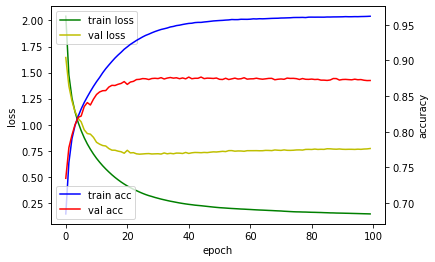

0.9619507789611816
0.871874988079071
0.14448168873786926
0.7717998623847961


In [186]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'r', label='val acc')

loss_ax.plot(history.history['loss'],'g', label='train loss')
loss_ax.plot(history.history['val_loss'],'y', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

print(history.history['acc'][-1])
print(history.history['val_acc'][-1])
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

In [171]:
#load model
best_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
best_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
             metrics=['acc'])
best_model.load_weights(chekpoint_filepath)

In [189]:
best_model

### Step 6 모델 평가하기
---
단어 단위 번역기에 대해서 훈련 데이터의 샘플과 테스트 데이터의 샘플에 대해서 번역 문장을 만들어보고 정답 문장과 번역 문장을 비교해보자.

In [190]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_20 (Embedding)     (None, None, 250)         1165750   
_________________________________________________________________
masking_20 (Masking)         (None, None, 250)         0         
_________________________________________________________________
lstm_20 (LSTM)               [(None, 250), (None, 250) 501000    
Total params: 1,666,750
Trainable params: 1,666,750
Non-trainable params: 0
_________________________________________________________________


In [191]:
# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [192]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [197]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [198]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + index_to_src[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_to_index['<sos>']) and i!=tar_to_index['<eos>']):
            temp = temp + index_to_tar[i] + ' '
    return temp

In [199]:
for seq_index in [3,50,100,300,1001, 162, 369]:
    input_seq = eng2vector_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print("원문 : ",seq2src(eng2vector_train[seq_index]))
    print("번역문 :",seq2tar(dec2vector_train[seq_index]))
    print("예측문 :",decoded_sentence[:-5])
    print("\n")

원문 :  they spoke briefly . 
번역문 : ils se sont bri vement entretenus . 
예측문 :  elles parl rent bri vement . 


원문 :  i got really mad . 
번역문 : je me suis vraiment mise en col re . 
예측문 :  je me suis vraiment mis en col re . 


원문 :  i wonder who . 
번역문 : je me demande qui . 
예측문 :  je me demande qui . 


원문 :  it was very ugly . 
번역문 : c tait tr s laid . 
예측문 :  c tait fort laid . 


원문 :  she became pregnant . 
번역문 : elle est tomb e enceinte . 
예측문 :  elle est tomb e enceinte . 


원문 :  i ve just seen tom . 
번역문 : je viens de voir tom . 
예측문 :  je viens de voir tom . 


원문 :  she met her uncle . 
번역문 : elle rencontra son oncle . 
예측문 :  elle a rencontr son oncle . 




## 고찰
  
인코딩과 디코딩 두개의 모델을 나눠서 학습을 시키는 과정이 생소했기 때문에 모델을 구현하는데에 어려움이 있었다.  
자연어 처리에서 항상 어려움이 있었던 토크나이즈와 임베딩 개념을 확실히 할 수 있는 시간이었다.  
  
Callback함수를 이용하여 모델 학습에 효율성을 높일려는 시도를 하였다.  
CosineAnnealingScheduler 클래스를 선언하여 학습률 조절을 시도하였는데 Validation data가 수렵해나가는 속도보다 학습률이 더 빠르게 떨어져 동일한 에폭으로 실험을 했을 때 고정 learning rate로 학습을 하는 것이 오히려 더 좋은 정확도와 더 낮은 loss를 얻을 수 있었다. 시도는 좋았으나 경험적으로 아직 부족하다고 판단된다.  
  
이미지는 동일한 사이즈를 가진다는 데이터를 제한하는 조건이 몇 개의 샘플만 시각화 하여도 데이터 전처리가 잘 적용되고 있는지 확인이 가능하지만 자연어는 가지고 있는 데이터의 길이가 다양하기 때문에 직관적으로 전처리가 잘 되고 있는지 확인하는데에 어려움이 있다.